# <font color='#F21905'>ADS CTR Forecasting

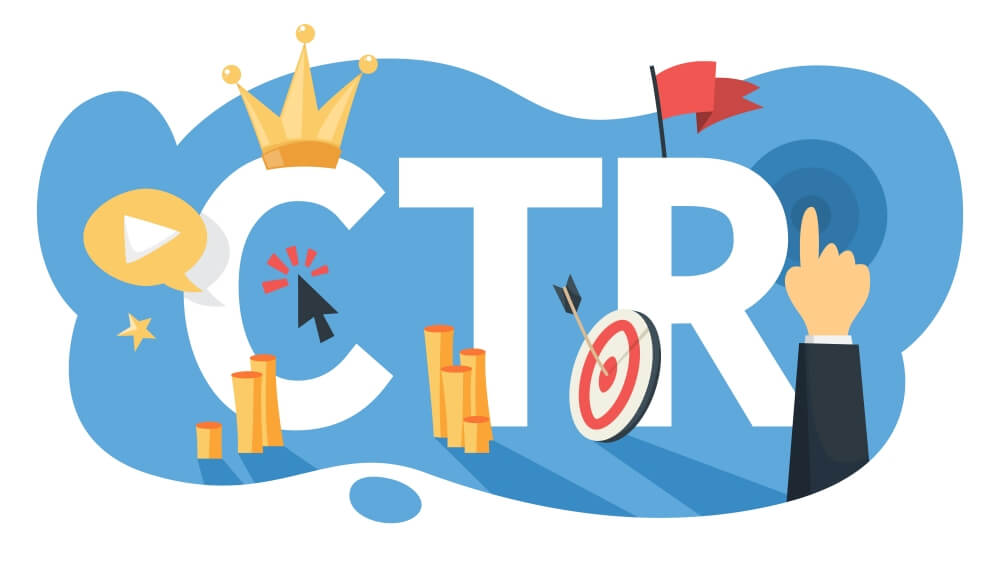

## <font color='#F21905'>**Introduction**
In digital advertising, measuring the effectiveness of an ad campaign is crucial for optimizing marketing strategies. One of the key performance indicators (KPIs) used in online advertising is the **Click-Through Rate (CTR)**, which represents the ratio of users who click on an advertisement to the number of times it is displayed (impressions). 

Predicting future CTR trends can help advertisers make **data-driven decisions**, allocate budgets effectively, and improve ad performance. This project focuses on building a **time series forecasting model** to predict future CTR values based on historical advertisement performance data.

## <font color='#F21905'>**Aim**
The goal of this project is to develop a predictive model that can forecast future CTR values by analyzing past click and impression data. The model will help in understanding trends, seasonal patterns, and anomalies in ad performance, allowing advertisers to **optimize their strategies and improve return on investment (ROI)**.

## <font color='#F21905'>**Dataset Overview**
The dataset consists of daily records of ad performance, including the number of **clicks, impressions**, and their respective timestamps.

### <font color='#F21905'>**Columns Description**
- **Date**: The date on which the data was recorded (YYYY-MM-DD format). This serves as the time index for forecasting.
- **Clicks**: The number of times users clicked on the ad on a given day.
- **Impressions**: The number of times the ad was displayed to users on a given day.

### <font color='#F21905'>**Target Variable**
The **Click-Through Rate (CTR)**, which is computed as:
$$
CTR = \frac{\text{Clicks}}{\text{Impressions}} \times 100
$$

This will be the primary metric we aim to forecast.

By analyzing this dataset, we can identify **trends, seasonality, and other factors** affecting CTR and develop a suitable forecasting model.


## <font color='#F21905'> Requirements

In [5]:
import pandas as pd
from datetime import date,timedelta
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

## <font color='#F21905'> Import Data

In [10]:
df=pd.read_csv('ctr.csv')

## <font color='#F21905'> EDA (Exploratory Data Analysis)

In [13]:
df.head()

,Date,Clicks,Impressions
0,2022-10-19,2851,58598
1,2022-10-20,2707,57628
2,2022-10-21,2246,50135
3,2022-10-22,1686,40608
4,2022-10-23,1808,41999


In [15]:
df.tail()

,Date,Clicks,Impressions
360,2023-10-14,885,28487
361,2023-10-15,1180,33440
362,2023-10-16,1624,41688
363,2023-10-17,1751,40957
364,2023-10-18,1573,40351


In [17]:
df.shape

(365, 3)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         365 non-null    object
 1   Clicks       365 non-null    int64 
 2   Impressions  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


In [21]:
df.isnull().sum()

Date           0
Clicks         0
Impressions    0
dtype: int64

## <font color='#F21905'> Feature Engineering

In [35]:
df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.set_index('Date',inplace=True)

In [49]:
df['CTR']=(df['Clicks']/df['Impressions'])*100

In [67]:
df['DayOfWeek']=df.index.dayofweek
df['WeekOfMonth'] = df.index.isocalendar().week.astype(int) // 4

In [77]:
df['DayCategory']=df['DayOfWeek'].apply(lambda x: 'Weekend' if x>=5 else 'Weekday')

In [79]:
df.sample(5)

,Clicks,Impressions,CTR,DayOfWeek,WeekOfMonth,DayCategory
Date,,,,,,
2023-10-09,1756,44926,3.908650,0,10,Weekday
2023-06-17,1093,35746,3.057685,5,6,Weekend
2023-02-24,2310,54957,4.203286,4,2,Weekday
2023-05-24,1989,49957,3.981424,2,5,Weekday
2023-07-19,2066,43284,4.773126,2,7,Weekday


## <font color='#F21905'> Data Visualizations

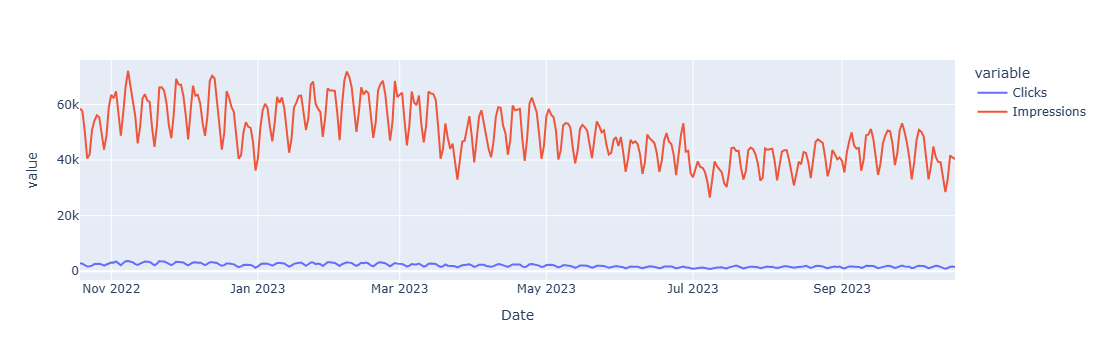

In [45]:
px.line(df,y=['Clicks','Impressions'])

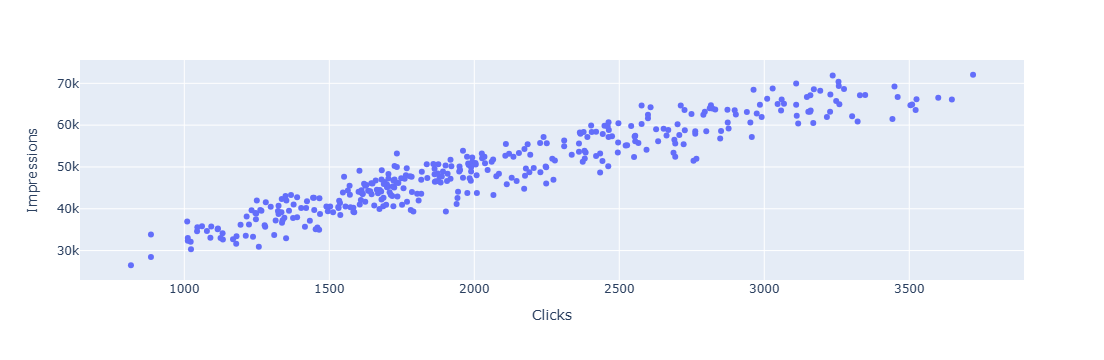

In [47]:
px.scatter(df,x='Clicks',y='Impressions')

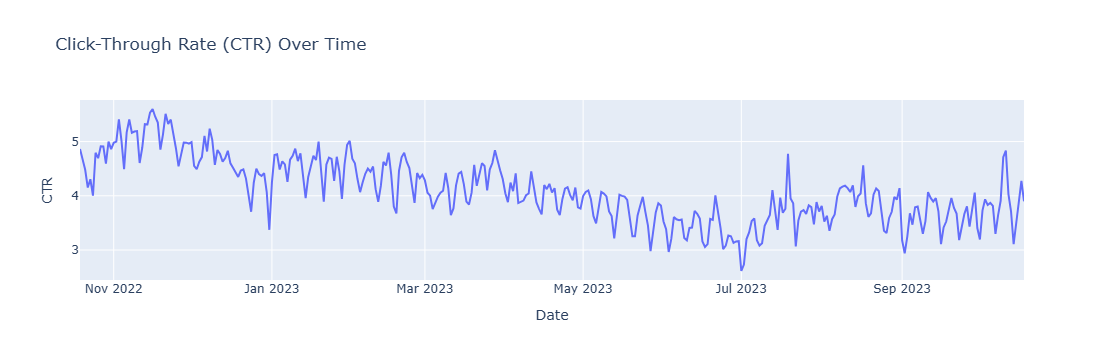

In [55]:
px.line(df,x=df.index,y='CTR',title='Click-Through Rate (CTR) Over Time')

In [73]:
day_of_week_ctr=df.groupby('DayOfWeek')['CTR'].mean().reset_index()
day_of_week_ctr['DayOfWeek']=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_of_week_ctr

,DayOfWeek,CTR
0,Monday,4.174384
1,Tuesday,4.274768
2,Wednesday,4.273197
3,Thursday,4.252425
4,Friday,3.995702
5,Saturday,3.688105
6,Sunday,3.976570


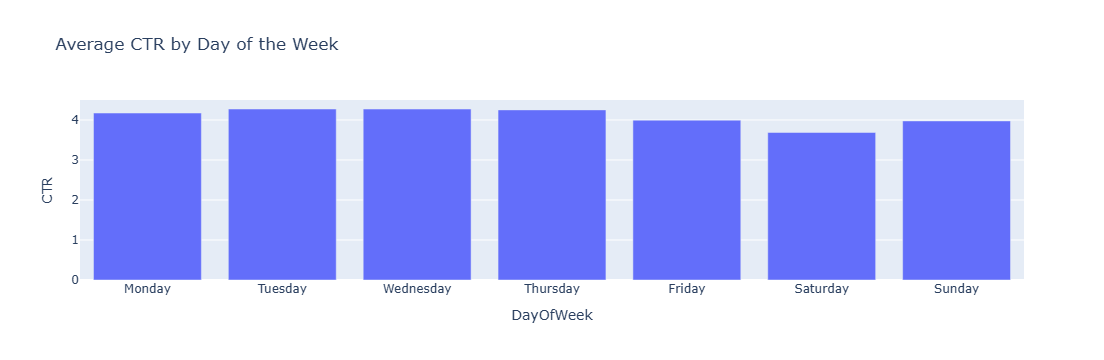

In [75]:
px.bar(day_of_week_ctr,x='DayOfWeek',y='CTR',title='Average CTR by Day of the Week')

In [81]:
ctr_by_day_category=df.groupby('DayCategory')['CTR'].mean().reset_index()
ctr_by_day_category

,DayCategory,CTR
0,Weekday,4.194398
1,Weekend,3.832338


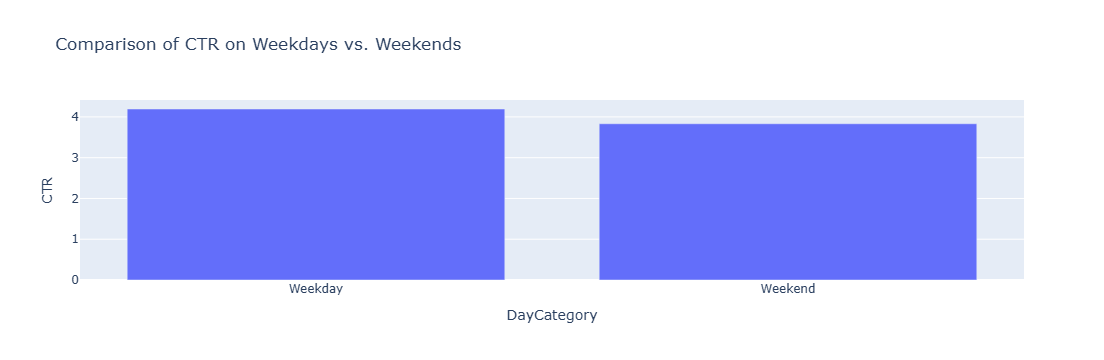

In [85]:
px.bar(ctr_by_day_category,x='DayCategory',y='CTR',title='Comparison of CTR on Weekdays vs. Weekends')

In [87]:
grouped_df=df.groupby('DayCategory')[['Clicks','Impressions']].sum().reset_index()
grouped_df

,DayCategory,Clicks,Impressions
0,Weekday,583303,13692003
1,Weekend,172383,4416639


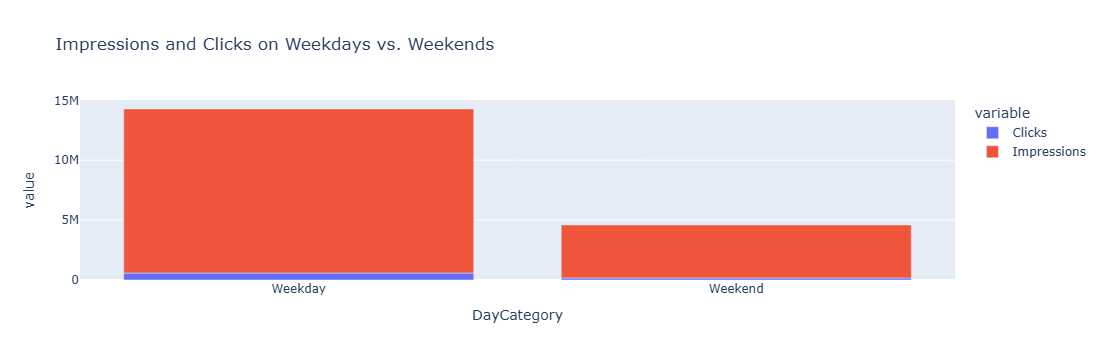

In [89]:
px.bar(grouped_df,x='DayCategory',y=['Clicks','Impressions'],title='Impressions and Clicks on Weekdays vs. Weekends')

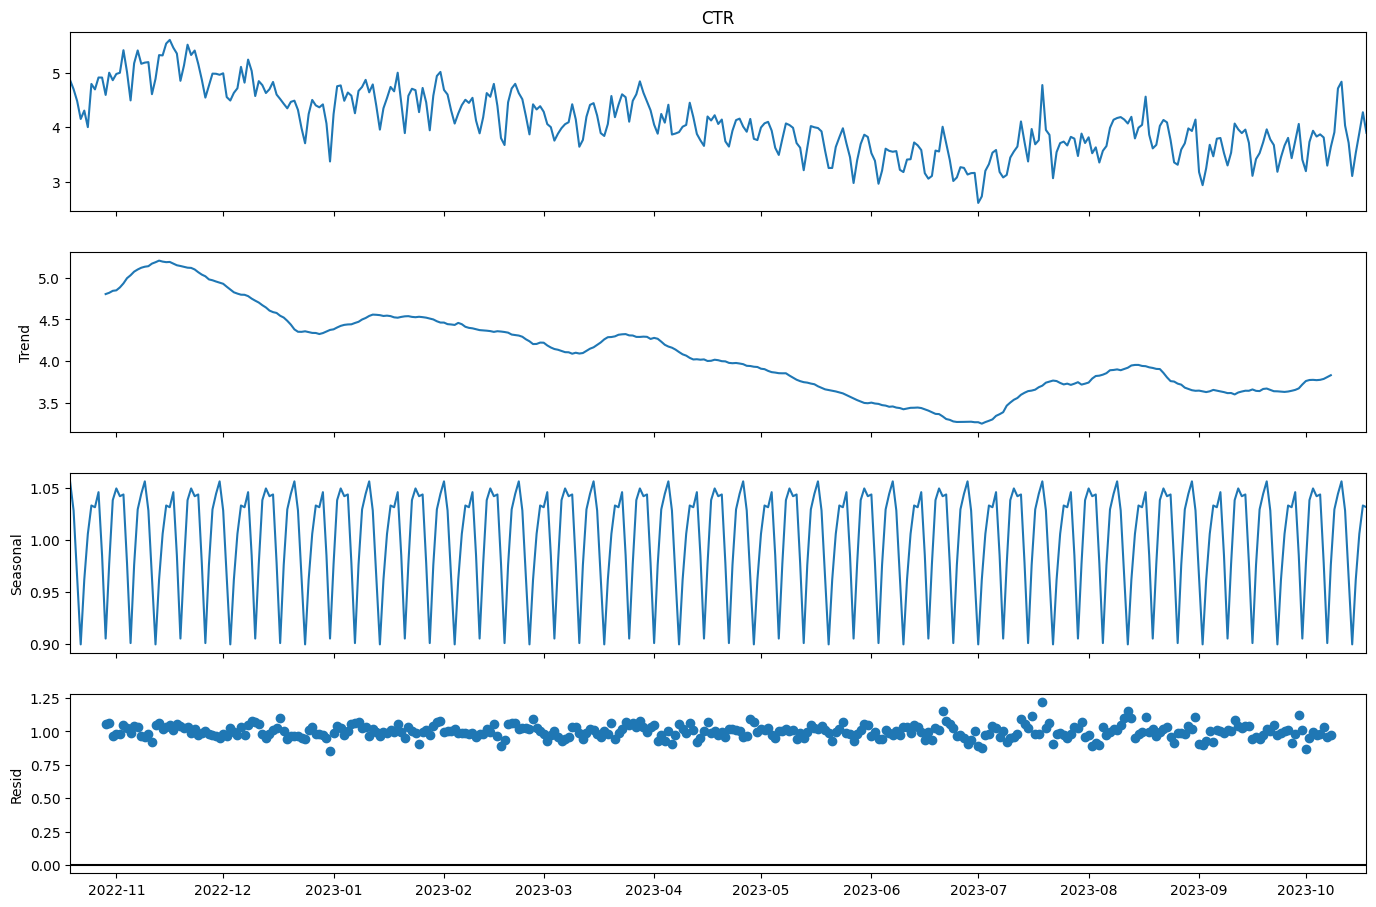

In [91]:
result=seasonal_decompose(df["CTR"],model="multiplicative",period=21)
fig=result.plot()
fig.set_size_inches(15,10)

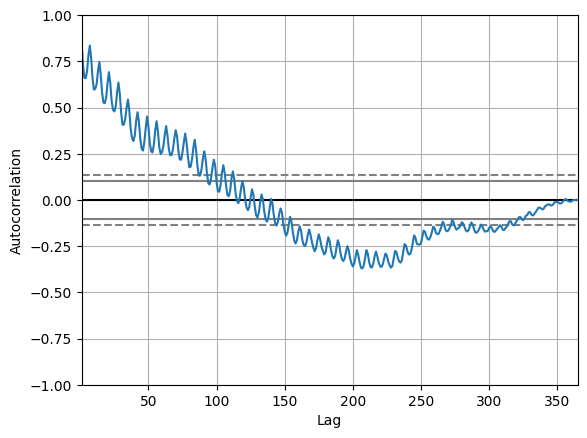

In [93]:
pd.plotting.autocorrelation_plot(df["CTR"]);

## <font color='#F21905'> Modelling

In [127]:
df.head()

,Clicks,Impressions,CTR,DayOfWeek,WeekOfMonth,DayCategory
Date,,,,,,
2022-10-19,2851,58598,4.865354,2,10,Weekday
2022-10-20,2707,57628,4.697369,3,10,Weekday
2022-10-21,2246,50135,4.479904,4,10,Weekday
2022-10-22,1686,40608,4.151891,5,10,Weekend
2022-10-23,1808,41999,4.304864,6,10,Weekend


In [137]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['CTR'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -71.365
Date:                            Sun, 02 Feb 2025   AIC                            152.729
Time:                                    22:13:41   BIC                            172.047
Sample:                                10-19-2022   HQIC                           160.417
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5266      0.070      7.514      0.000       0.389       0.664
ma.L1         -0.9049      0.036    -25.364      0.000      -0.975      -0.835
ar.S.L12      -0.1574      0.071     -2.227      0.026      -0.296      -0.019
ma.S.L12      -0.9982      1.547     -0.645      0.519      -4.031       2.034
sigma2         0.0772      0.119      0.650      0.516      -0.156       0.310
===================================================================================
Ljung-Box (L1) (Q):                   5.64   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.02   Prob(JB):                         0.55
Heteroskedasticity (H):               1.14   Skew:                            -0.01
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
predictions=result.predict(len(df),len(df)+100)
predictions

2023-10-19    3.852369
2023-10-20    3.889405
2023-10-21    3.820210
2023-10-22    3.727335
2023-10-23    3.710170
                ...   
2024-01-23    3.466440
2024-01-24    3.560983
2024-01-25    3.546493
2024-01-26    3.579903
2024-01-27    3.584109
Freq: D, Name: predicted_mean, Length: 101, dtype: float64

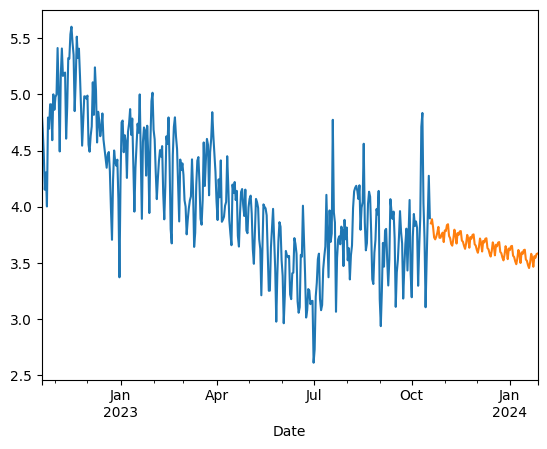

In [139]:
df["CTR"].plot()
predictions.plot();

## <font color='#F21905'> Conclusion  

In this study, we analyzed historical Click-Through Rate (**CTR**) data and built a forecasting model to predict future trends. The CTR has shown a gradual decline over the past year with occasional fluctuations. Using our predictive model, we forecasted CTR values for the next 100 days.  

The forecasted results indicate a **slight downward trend**, suggesting that CTR may continue to decline in the upcoming months. However, there are small fluctuations in the predicted values, indicating potential short-term variations.  

The accuracy and reliability of these predictions depend on various factors, including external influences on ad performance, seasonality, and possible market changes. Further improvements can be achieved by incorporating additional features, fine-tuning the model, or experimenting with different forecasting techniques.  